In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
import shutil
import math
import random
import heapq 
import time
import copy
import itertools  
from typing import Dict, List
from PIL import Image
from io import StringIO,BytesIO 
from scipy.spatial.distance import pdist
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,auc,roc_auc_score 
from sklearn.decomposition import PCA
from functools import reduce
from scipy.io import loadmat
import cv2
import faiss 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.ops as ops
torch.cuda.set_device(0)
print (torch.cuda.current_device())

Loading faiss with AVX2 support.


0


In [2]:
tstart = time.time()
root_dir = '/data/fjsdata/MCBIR-Ins/TNSCUI2020_train/' #the path of images
trData = pd.read_csv(root_dir+"trainset.csv" , sep=',')
teData = pd.read_csv(root_dir+"testset.csv" , sep=',')
#trainset 
trN, trI, trM, trY = [],[],[],[]
for iname, itype in np.array(trData).tolist():
    try:
        trN.append(iname)
        trY.append(itype) #0 refer to Benign, and 1 refers to malignant
        image_path = os.path.join(root_dir, 'image', iname)
        img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(256,256,3)
        trI.append(img)
        mask_path = os.path.join(root_dir,'mask', iname)
        mask = cv2.resize(cv2.imread(mask_path).astype(np.float32), (256, 256))#(256,256)
        trM.append(mask)
    except:
        print(iname+":"+str(image_path))
    sys.stdout.write('\r{} / {} '.format(len(trN),trData.shape[0]))
    sys.stdout.flush()
print('The length of trainset is %d'%len(trN))
#testset
teN, teI, teM, teY = [],[],[],[]
for iname, itype in np.array(teData).tolist():
    try:
        teN.append(iname)
        teY.append(itype) #0 refer to Benign, and 1 refers to malignant
        image_path = os.path.join(root_dir, 'image', iname)
        img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(256,256,3)
        teI.append(img)
        mask_path = os.path.join(root_dir,'mask', iname)
        mask = cv2.resize(cv2.imread(mask_path).astype(np.float32), (256, 256))#(256,256)
        teM.append(mask)
    except:
        print(iname+":"+str(image_path))
    sys.stdout.write('\r{} / {} '.format(len(teN),teData.shape[0]))
    sys.stdout.flush()
print('The length of testset is %d'%len(teN))

elapsed = time.time() - tstart
print('Completed data handle in %d seconds' % int(elapsed))

3279 / 3279 The length of trainset is 3279
365 / 365 The length of testset is 365
Completed data handle in 100 seconds


In [3]:
__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        feat = self.layer4(x)

        x = self.avgpool(feat)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return feat, x


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model


def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model


def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model


def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model

 328 / 328 : loss = 0.676999Eopch:     1 mean_loss = 0.762210
 328 / 328 : loss = 0.561823Eopch:     2 mean_loss = 0.703054
 328 / 328 : loss = 0.754054Eopch:     3 mean_loss = 0.694404
 328 / 328 : loss = 0.724318Eopch:     4 mean_loss = 0.699685
 328 / 328 : loss = 0.674195Eopch:     5 mean_loss = 0.692434
 328 / 328 : loss = 0.695095Eopch:     6 mean_loss = 0.692761
 328 / 328 : loss = 0.677172Eopch:     7 mean_loss = 0.693483
 328 / 328 : loss = 0.660955Eopch:     8 mean_loss = 0.683284
 328 / 328 : loss = 0.696925Eopch:     9 mean_loss = 0.679376
 328 / 328 : loss = 0.652352Eopch:    10 mean_loss = 0.682291
best_loss = 0.679376
 36 / 37 Sensitivity(TPR) of Benign: 0.494186
Sensitivity(TPR) of Malignant: 0.569948
AUC (Area Under Curve) of Micro: 0.481775


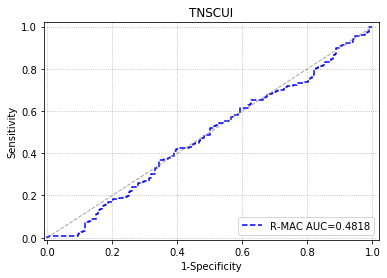

In [14]:
#define model
model = resnet101(num_classes=2).cuda()#initialize model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
ce_loss  = nn.CrossEntropyLoss().cuda() #define cross-entropy loss
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
for epoch in range(10):#iteration
    losses = []
    shuffled_idx = np.random.permutation(np.arange(len(trI)))
    trI_batch = np.array(trI)[shuffled_idx]
    trY_batch = np.array(trY)[shuffled_idx]
    num_batches = len(trI) // batchSize + 1
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trI), (i+1)*batchSize])
        X_batch = torch.from_numpy(trI_batch[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Y_batch = torch.from_numpy(trY_batch[min_idx:max_idx]).type(torch.LongTensor).cuda()
        #forword
        _,Out_batch = model(X_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        loss = ce_loss(Out_batch,Y_batch)#loss
        #backward
        loss.backward()
        optimizer.step()#update parameters
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))
#release gpu memory
model = model.cpu()
ce_loss = ce_loss.cpu()
torch.cuda.empty_cache()

#test model
teY_pred = []
teY_prob = []
num_batches = len(teI) // batchSize + 1
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(teI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    _,out_batch = best_net(x_batch.permute(0, 3, 1, 2))#forword
    out_batch = F.log_softmax(out_batch,dim=1) 
    prob = out_batch.max(1,keepdim=True)[0]
    teY_prob.extend(prob.cpu().data.numpy().tolist())
    pred = out_batch.max(1,keepdim=True)[1]
    teY_pred.extend(pred.cpu().data.numpy().flatten().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#TNR= TN / (FP+TN) ->low misdiagnosis rate->Specificity
#TPR= TP / (TP+FN) -> low missed diagnosis rate->Sensitivity
#ROC curves: y axis:Sensitivity, x axis:1-Specificity
#confusion matrix
labels = list(set(teY))
cm = confusion_matrix(teY, teY_pred, labels=labels) 
print ('Sensitivity(TPR) of Benign: %.6f'%float(cm[0][0]/np.sum(cm[0]))) 
print ('Sensitivity(TPR) of Malignant: %.6f'%float(cm[1][1]/np.sum(cm[1])))
#auc and roc
teY_one_hot = label_binarize(np.array(teY), np.arange(len(labels)))
auc_score = roc_auc_score(teY_one_hot, np.array(teY_prob), average='micro')#macro
print ('AUC (Area Under Curve) of Micro: %.6f'% auc_score)
#plot roc curve
fpr_tce, tpr_tce, thresholds = roc_curve(teY_one_hot.ravel(),np.array(teY_prob).ravel()) 
#plt.plot(fpr_ce, tpr_ce, c = 'r', ls = '--', label = u'ATH(our) AUC=%.4f' % auc_score)
plt.plot(fpr_tce, tpr_tce, c = 'b', ls = '--', label = u'R-MAC AUC=%.4f' % auc_score) 
plt.plot((0, 1), (0, 1), c = '#808080', lw = 1, ls = '--', alpha = 0.7)
plt.xlim((-0.01, 1.02))
plt.ylim((-0.01, 1.02))
plt.xticks(np.arange(0, 1.1, 0.2))
plt.yticks(np.arange(0, 1.1, 0.2))
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.grid(b=True, ls=':')
plt.legend(loc='lower right')
plt.title('TNSCUI')
plt.show()

In [15]:
#release gpu memory and save model in CPU
model = model.cpu()
ce_loss = ce_loss.cpu()
X_batch= X_batch.cpu()
Y_batch= Y_batch.cpu()
best_net = best_net.cpu()
torch.cuda.empty_cache() 
torch.save(best_net.state_dict(), '/data/tmpexec/RegionalAttention.pkl')

In [16]:
'''
#Code: https://github.com/jaeyoon1603/Retrieval-RegionalAttention
#Paper: BMVC2018《Regional Attention Based Deep Feature for Image Retrieval》
'''
def get_rmac_region_coordinates(H, W, L):
    # Almost verbatim from Tolias et al Matlab implementation.
    # Could be heavily pythonized, but really not worth it...
    # Desired overlap of neighboring regions
    ovr = 0.4
    # Possible regions for the long dimension
    steps = np.array((2, 3, 4, 5, 6, 7), dtype=np.float32)
    w = np.minimum(H, W)
    
    b = (np.maximum(H, W) - w) / (steps - 1)
    # steps(idx) regions for long dimension. The +1 comes from Matlab
    # 1-indexing...
    idx = np.argmin(np.abs(((w**2 - w * b) / w**2) - ovr)) + 1
    
    # Region overplus per dimension
    Wd = 0
    Hd = 0
    if H < W:
        Wd = idx
    elif H > W:
        Hd = idx
    
    regions_xywh = []
    for l in range(1, L+1):
        wl = np.floor(2 * w / (l + 1))
        wl2 = np.floor(wl / 2 - 1)
        # Center coordinates
        if l + Wd - 1 > 0:
            b = (W - wl) / (l + Wd - 1)
        else:
            b = 0
        cenW = np.floor(wl2 + b * np.arange(l - 1 + Wd + 1)) - wl2
        # Center coordinates
        if l + Hd - 1 > 0:
            b = (H - wl) / (l + Hd - 1)
        else:
            b = 0
        cenH = np.floor(wl2 + b * np.arange(l - 1 + Hd + 1)) - wl2
    
        for i_ in cenH:
            for j_ in cenW:
                regions_xywh.append([j_, i_, wl, wl])
    
    # Round the regions. Careful with the borders!
    for i in range(len(regions_xywh)):
        for j in range(4):
            regions_xywh[i][j] = int(round(regions_xywh[i][j]))
        if regions_xywh[i][0] + regions_xywh[i][2] > W:
            regions_xywh[i][0] -= ((regions_xywh[i][0] + regions_xywh[i][2]) - W)
        if regions_xywh[i][1] + regions_xywh[i][3] > H:
            regions_xywh[i][1] -= ((regions_xywh[i][1] + regions_xywh[i][3]) - H)
    return np.array(regions_xywh).astype(np.float32)

def pack_regions_for_network(all_regions):
    n_regs = np.sum([len(e) for e in all_regions])
    R = np.zeros((n_regs, 5), dtype=np.float32)
    cnt = 0
    # There should be a check of overflow...
    for i, r in enumerate(all_regions):
        try:
            R[cnt:cnt + r.shape[0], 0] = i
            R[cnt:cnt + r.shape[0], 1:] = r
            cnt += r.shape[0]
        except:
            continue
    assert cnt == n_regs
    R = R[:n_regs]
    # regs where in xywh format. R is in xyxy format, where the last coordinate is included. Therefore...
    R[:n_regs, 3] = R[:n_regs, 1] + R[:n_regs, 3] - 1
    R[:n_regs, 4] = R[:n_regs, 2] + R[:n_regs, 4] - 1
    return R

class L2Normalization(nn.Module):
    def __init__(self):
        """
        In the constructor we construct three nn.Linear instances that we will use
        in the forward pass.
        """
        super(L2Normalization, self).__init__()
        self.eps = 1e-8
        
    def forward(self, x):
        if x.is_cuda:
            caped_eps = Variable(torch.Tensor([self.eps])).cuda(torch.cuda.device_of(x).idx)
        else:
            caped_eps = Variable(torch.Tensor([self.eps]))
        x = torch.div(x.transpose(0,1),x.max(1)[0]).transpose(0,1) # max_normed
        norm = torch.norm(x,2,1) + caped_eps.expand(x.size()[0])
        y = torch.div(x.transpose(0,1),norm).transpose(0,1)
        return y


class Shift(nn.Module):
    def __init__(self,dim):
        super(Shift, self).__init__()
        #self.bias = nn.Parameter(torch.ones(dim))
        self.bias = nn.Parameter(torch.Tensor(dim))
        self.bias.data.uniform_(-0.006, -0.03)
    def forward(self, input):
        output = torch.add(input, self.bias)
        
        return output
    
class RoIPool(nn.Module):
    def __init__(self, pooled_height, pooled_width, spatial_scale):
        super(RoIPool, self).__init__()
        self.pooled_width = int(pooled_width)
        self.pooled_height = int(pooled_height)
        self.spatial_scale = float(spatial_scale)

    def forward(self, features, rois):
        batch_size, num_channels, data_height, data_width = features.size()
        num_rois = rois.size()[0]
        
        outputs = Variable(torch.zeros(num_rois, num_channels,
                                       self.pooled_height,
                                       self.pooled_width))
        if features.is_cuda:
            outputs = outputs.cuda(torch.cuda.device_of(features).idx)

        for roi_ind, roi in enumerate(rois):
            batch_ind = int(roi[0].item())
            roi_start_w, roi_start_h, roi_end_w, roi_end_h = torch.round(roi[1:]* self.spatial_scale).data.cpu().numpy().astype(int)
            roi_width = max(roi_end_w - roi_start_w + 1, 1)
            roi_height = max(roi_end_h - roi_start_h + 1, 1)
            bin_size_w = float(roi_width) / float(self.pooled_width)
            bin_size_h = float(roi_height) / float(self.pooled_height)

            for ph in range(self.pooled_height):
                hstart = int(np.floor(ph * bin_size_h))
                hend = int(np.ceil((ph + 1) * bin_size_h))
                hstart = min(data_height, max(0, hstart + roi_start_h))
                hend = min(data_height, max(0, hend + roi_start_h))
                for pw in range(self.pooled_width):
                    wstart = int(np.floor(pw * bin_size_w))
                    wend = int(np.ceil((pw + 1) * bin_size_w))
                    wstart = min(data_width, max(0, wstart + roi_start_w))
                    wend = min(data_width, max(0, wend + roi_start_w))

                    is_empty = (hend <= hstart) or(wend <= wstart)
                    if is_empty:
                        outputs[roi_ind, :, ph, pw] = 0
                    else:
                        data = features[batch_ind]
                        outputs[roi_ind, :, ph, pw] = torch.max(
                            torch.max(data[:, hstart:hend, wstart:wend], 1, keepdim = True)[0], 2, keepdim = True)[0].view(-1)  # noqa

        return outputs
    
class ContextAwareRegionalAttentionNetwork(nn.Module):
    def __init__(self, spatial_scale, pooled_height = 1, pooled_width = 1):
        super(ContextAwareRegionalAttentionNetwork, self).__init__()
        self.pooled_width = int(pooled_width)
        self.pooled_height = int(pooled_height)
        self.spatial_scale = float(spatial_scale)
        
        self.conv_att_1 = nn.Conv1d(4096, 64, 1, padding=0)
        self.sp_att_1 = nn.Softplus()
        self.conv_att_2 = nn.Conv1d(64, 1, 1, padding=0)
        self.sp_att_2 = nn.Softplus()
        

    def forward(self, features, rois):
        batch_size, num_channels, data_height, data_width = features.size()
        num_rois = rois.size()[0]
        
        outputs = Variable(torch.zeros(num_rois, num_channels*2,
                                       self.pooled_height,
                                       self.pooled_width))
        if features.is_cuda:
            outputs = outputs.cuda(torch.cuda.device_of(features).idx)
            
        # Based on roi pooling code of pytorch but, the only difference is to change max pooling to mean pooling
        for roi_ind, roi in enumerate(rois):
            batch_ind = int(roi[0].item())
            roi_start_w, roi_start_h, roi_end_w, roi_end_h =  torch.round(roi[1:]* self.spatial_scale).data.cpu().numpy().astype(int)
            roi_width = max(roi_end_w - roi_start_w + 1, 1)
            roi_height = max(roi_end_h - roi_start_h + 1, 1)
            bin_size_w = float(roi_width) / float(self.pooled_width)
            bin_size_h = float(roi_height) / float(self.pooled_height)

            for ph in range(self.pooled_height):
                hstart = int(np.floor(ph * bin_size_h))
                hend = int(np.ceil((ph + 1) * bin_size_h))
                hstart = min(data_height, max(0, hstart + roi_start_h))
                hend = min(data_height, max(0, hend + roi_start_h))
                for pw in range(self.pooled_width):
                    wstart = int(np.floor(pw * bin_size_w))
                    wend = int(np.ceil((pw + 1) * bin_size_w))
                    wstart = min(data_width, max(0, wstart + roi_start_w))
                    wend = min(data_width, max(0, wend + roi_start_w))

                    is_empty = (hend <= hstart) or(wend <= wstart)
                    if is_empty:
                        outputs[roi_ind, :, ph, pw] = 0
                    else:
                        data = features[batch_ind]
                        # mean pooling with both of regional feature map and global feature map
                        outputs[roi_ind, :, ph, pw] = torch.cat((torch.mean(
                            torch.mean(data[:, hstart:hend, wstart:wend], 1, keepdim = True), 2, keepdim = True).view(-1)
                            ,torch.mean(
                            torch.mean(data, 1, keepdim = True), 2, keepdim = True).view(-1)), 0 )  # noqa
                        
        # Reshpae
        outputs = outputs.squeeze(2).squeeze(2)
        outputs = outputs.transpose(0,1).unsqueeze(0) # (1, # channel, #batch * # regions)
        #Calculate regional attention weights with context-aware regional feature vectors
        k = self.sp_att_1(self.conv_att_1(outputs))
        k = self.sp_att_2(self.conv_att_2(k)) # (1, 1, #batch * # regions)
        k = torch.squeeze(k,1)
        
        return k
    
class NetForTraining(nn.Module):

    def __init__(self, res_net, num_classes):
        super(NetForTraining, self).__init__()
        
        self.l2norm = L2Normalization()
        
        #RoI max pooling
        self.r_mac_pool = RoIPool(1,1,0.03125)
        self.region_attention = ContextAwareRegionalAttentionNetwork(spatial_scale = 0.03125)
        self._initialize_weights()
        
        #This is for Imagenet classification. get the weights of fc from off-the-shelf Resnet101.
        self.fc = nn.Linear(2048,num_classes)
        self.resnet = res_net
        dic = self.resnet.state_dict()
        self.fc.weight.data = dic['fc.weight']
        self.fc.bias.data = dic['fc.bias']
          
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
    
   
    def forward(self, x ):
        #Calculate R-MAC regions (Region sampling)
        batched_rois =  [get_rmac_region_coordinates(x.shape[2],x.shape[3],5) for i in range(x.shape[0])]
        rois = Variable(torch.FloatTensor(pack_regions_for_network(batched_rois)))
        
        h = x
        #Extract feature map
        h,_ = self.resnet(x) #( #batch, #channel, #h, #w)
        #R-MAC
        g = self.r_mac_pool(h,rois) 
        g = g.squeeze(2).squeeze(2) # (#batch * # regions, #channel)
        #Regional Attention
        g2 = self.region_attention(h,rois)
        g2 = g2.squeeze(0).squeeze(0)# (# batch * region)
        #weighted mean
        g = torch.mul(g.transpose(1,0),g2).transpose(1,0)  # regional weighted feature (# batch * region, #channel)
        g = g.contiguous()
        g = g.view(torch.Size([h.size(0), -1 ,h.size(1)])) # (#batch, # region, # channel)
        g = torch.transpose(g,1,2)    # (#batch * #channel, #region)
        
        g_feat = torch.mean(g,2) #mean
        g_feat = self.l2norm(g_feat)
        
        g = self.fc(g_feat)

        return g_feat, g

 328 / 328 : loss = 0.170417Eopch:     1 mean_loss = 0.172307
 328 / 328 : loss = 0.169328Eopch:     2 mean_loss = 0.172311
 328 / 328 : loss = 0.169709Eopch:     3 mean_loss = 0.172321
 328 / 328 : loss = 0.170148Eopch:     4 mean_loss = 0.172344
 328 / 328 : loss = 0.169272Eopch:     5 mean_loss = 0.172227
 328 / 328 : loss = 0.173481Eopch:     6 mean_loss = 0.172247
 328 / 328 : loss = 0.172026Eopch:     7 mean_loss = 0.172331
 328 / 328 : loss = 0.173506Eopch:     8 mean_loss = 0.172254
 328 / 328 : loss = 0.172954Eopch:     9 mean_loss = 0.172287
 328 / 328 : loss = 0.174323Eopch:    10 mean_loss = 0.172380
best_loss = 0.172227
 36 / 37 Sensitivity(TPR) of Benign: 0.284884
Sensitivity(TPR) of Malignant: 0.797927
AUC (Area Under Curve) of Micro: 0.542219


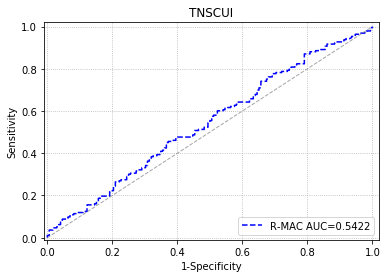

In [17]:
#load model and transfer to GPU
device = torch.device("cuda")
res_net = resnet101(num_classes=2)
res_net.load_state_dict(torch.load( '/data/tmpexec/RegionalAttention.pkl'))
res_net.to(device)

#nettraining
batchSize=10
model = NetForTraining(res_net=res_net,num_classes=2).cuda()
optimizer_ft = torch.optim.SGD(list(model.parameters())[:4], lr=0.001, momentum=0.9, weight_decay = 0.00005)
criterion =nn.CrossEntropyLoss().cuda()
best_net, best_loss = None, float('inf')
for epoch in range(10):#iteration
    losses = []
    shuffled_idx = np.random.permutation(np.arange(len(trI)))
    trI_batch = np.array(trI)[shuffled_idx]
    trY_batch = np.array(trY)[shuffled_idx]
    num_batches = len(trI) // batchSize + 1
    for i in range(num_batches):
        optimizer_ft.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trI), (i+1)*batchSize])
        X_batch = torch.from_numpy(trI_batch[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Y_batch = torch.from_numpy(trY_batch[min_idx:max_idx]).type(torch.LongTensor).cuda()
        _,out_batch = model(X_batch.permute(0, 3, 1, 2))
        _, preds = torch.max(out_batch.data, 1)
        loss = torch.div(criterion(out_batch,Y_batch),4)
        loss.backward()
        optimizer_ft.step()#update parameters
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))
#release gpu memory
model = model.cpu()
criterion = criterion.cpu()
torch.cuda.empty_cache()

#test model
teY_pred = []
teY_prob = []
num_batches = len(teI) // batchSize + 1
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(teI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    _,out_batch = best_net(x_batch.permute(0, 3, 1, 2))#forword
    out_batch = F.log_softmax(out_batch,dim=1) 
    prob = out_batch.max(1,keepdim=True)[0]
    teY_prob.extend(prob.cpu().data.numpy().tolist())
    pred = out_batch.max(1,keepdim=True)[1]
    teY_pred.extend(pred.cpu().data.numpy().flatten().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#TNR= TN / (FP+TN) ->low misdiagnosis rate->Specificity
#TPR= TP / (TP+FN) -> low missed diagnosis rate->Sensitivity
#ROC curves: y axis:Sensitivity, x axis:1-Specificity
#confusion matrix
labels = list(set(teY))
cm = confusion_matrix(teY, teY_pred, labels=labels) 
print ('Sensitivity(TPR) of Benign: %.6f'%float(cm[0][0]/np.sum(cm[0]))) 
print ('Sensitivity(TPR) of Malignant: %.6f'%float(cm[1][1]/np.sum(cm[1])))
#auc and roc
teY_one_hot = label_binarize(np.array(teY), np.arange(len(labels)))
auc_score = roc_auc_score(teY_one_hot, np.array(teY_prob), average='micro')#macro
print ('AUC (Area Under Curve) of Micro: %.6f'% auc_score)
#plot roc curve
fpr_tce, tpr_tce, thresholds = roc_curve(teY_one_hot.ravel(),np.array(teY_prob).ravel()) 
#plt.plot(fpr_ce, tpr_ce, c = 'r', ls = '--', label = u'ATH(our) AUC=%.4f' % auc_score)
plt.plot(fpr_tce, tpr_tce, c = 'b', ls = '--', label = u'R-MAC AUC=%.4f' % auc_score) 
plt.plot((0, 1), (0, 1), c = '#808080', lw = 1, ls = '--', alpha = 0.7)
plt.xlim((-0.01, 1.02))
plt.ylim((-0.01, 1.02))
plt.xticks(np.arange(0, 1.1, 0.2))
plt.yticks(np.arange(0, 1.1, 0.2))
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.grid(b=True, ls=':')
plt.legend(loc='lower right')
plt.title('TNSCUI')
plt.show()

In [18]:
res_net = res_net.cpu()
model = model.cpu()
criterion = criterion.cpu()
Y_batch =Y_batch.cpu()
X_batch = X_batch.cpu()
torch.cuda.empty_cache() 

In [19]:
batchSize=10
trF = []
num_batches = len(trI) // batchSize + 1
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(trI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    feat_batch,_ = best_net(x_batch.permute(0, 3, 1, 2))#forword
    trF.extend(feat_batch.detach().cpu().numpy().tolist())
teF = []
num_batches = len(teI) // batchSize + 1
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    x_batch = torch.from_numpy(np.array(teI[min_idx:max_idx])).type(torch.FloatTensor).cuda()
    feat_batch,_ = best_net(x_batch.permute(0, 3, 1, 2))#forword
    teF.extend(feat_batch.detach().cpu().numpy().tolist())
    
#compute the size of lesion
def Func_IOU_size(pred,target):
    ious = []
    # ignore IOU for background class
    pred_inds = pred != 0
    pred_sum = pred_inds.sum()
    target_inds = target != 0
    target_sum = target_inds.sum()
    ious.append(round(float(min(pred_sum,target_sum)/max(pred_sum,target_sum)),4))
    return np.mean(ious)
# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(2048) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
for topk in [10]:
    mAP = [] #mean average precision
    mIoU = []
    scores, neighbors = gpu_index.search(np.array(teF).astype('float32'), k=topk)
    for i, teVal in enumerate(teF):
        stype = teY[i]
        #perfromance
        pos_len = 0
        rank_len = 0
        #for j in ranklist:
        for j in neighbors[i].tolist():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                pos_len = pos_len +1
                mAP.append(pos_len/rank_len) 
            else: 
                mAP.append(0)
            mIoU.append(Func_IOU_size(teM[i],trM[j]))
    print("mAP={:.4f}, mIoU={:.4f}".format(np.mean(mAP),np.mean(mIoU)))

Completed buliding index in 23 seconds
mAP=0.3693, mIoU=0.3980


In [17]:
datas = pd.read_csv(root_dir+"labels.csv" , sep=',')
datas = datas[['filename','diagnosis(glaucoma=True)']]
print(datas['diagnosis(glaucoma=True)'].value_counts())
trData, teData = train_test_split(datas, test_size=0.1) #split trainset and testset
print(trData['diagnosis(glaucoma=True)'].value_counts())
print(teData['diagnosis(glaucoma=True)'].value_counts())
trData.to_csv( '/data/fjsdata/MCBIR-Ins/origa650/trainset.csv',index=False)
teData.to_csv( '/data/fjsdata/MCBIR-Ins/origa650/testset.csv',index=False)

False    482
True     168
Name: diagnosis(glaucoma=True), dtype: int64
False    433
True     152
Name: diagnosis(glaucoma=True), dtype: int64
False    49
True     16
Name: diagnosis(glaucoma=True), dtype: int64
